https://www.kaggle.com/competitions/energy-anomaly-detection/overview  
Metadata + additional data from https://www.kaggle.com/competitions/ashrae-energy-prediction/data


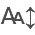

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import holidays
from scipy.stats import zscore
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import itertools
from sklearn.metrics import f1_score, classification_report, accuracy_score, precision_score, recall_score, fbeta_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from itables import init_notebook_mode
import jscatter
import numpy as np
import math
from ipywidgets import interact

init_notebook_mode(all_interactive=True)

In [2]:
%matplotlib widget

# Weather Data

In [3]:
# Load data
weather_data = pd.read_csv("datasets/energy-anomaly-detection/weather_train.csv")

In [4]:
# Convert timestamp to datetime data type
weather_data['timestamp'] = pd.to_datetime(weather_data['timestamp'])

In [5]:
weather_data.describe()

site_id                      timestamp  air_temperature  \
count  139773.000000                         139773    139718.000000   
mean        7.478977  2016-07-02 07:17:57.942092032        14.418106   
min         0.000000            2016-01-01 00:00:00       -28.900000   
25%         3.000000            2016-04-02 02:00:00         7.200000   
50%         7.000000            2016-07-02 09:00:00        15.000000   
75%        11.000000            2016-10-01 16:00:00        22.200000   
max        15.000000            2016-12-31 23:00:00        47.200000   
std         4.604744                            NaN        10.626595   

       cloud_coverage  dew_temperature  precip_depth_1_hr  sea_level_pressure  \
count    70600.000000    139660.000000       89484.000000       129155.000000   
mean         2.149306         7.350158           0.983047         1016.158038   
min          0.000000       -35.000000          -1.000000          968.200000   
25%          0.000000         0.600000           0.000000         1011.800000   
50%          2.000000         8.300000           0.000000         1016.400000   
75%          4.000000        14.400000           0.000000         1020.800000   
max          9.000000        26.100000         343.000000         1045.500000   
std          2.599150         9.790235           8.463678            7.629684   

       wind_direction     wind_speed  
count   133505.000000  139469.000000  
mean       180.526632       3.560527  
min          0.000000       0.000000  
25%         80.000000       2.100000  
50%        190.000000       3.100000  
75%        280.000000       5.000000  
max        360.000000      19.000000  
std        111.523629       2.335874

In [6]:
# Check for missing values in weather data
weather_data.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

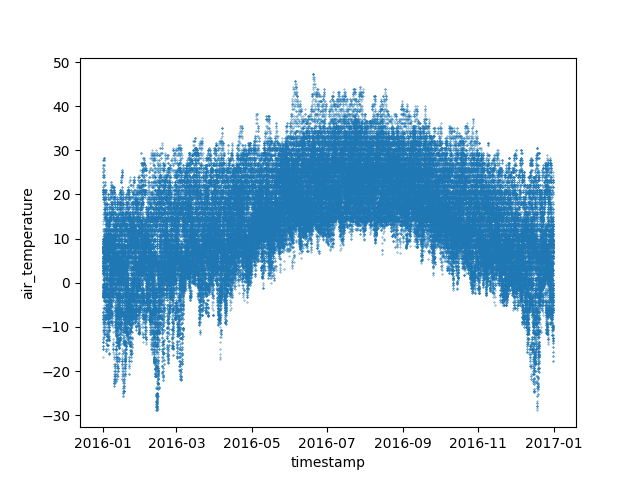

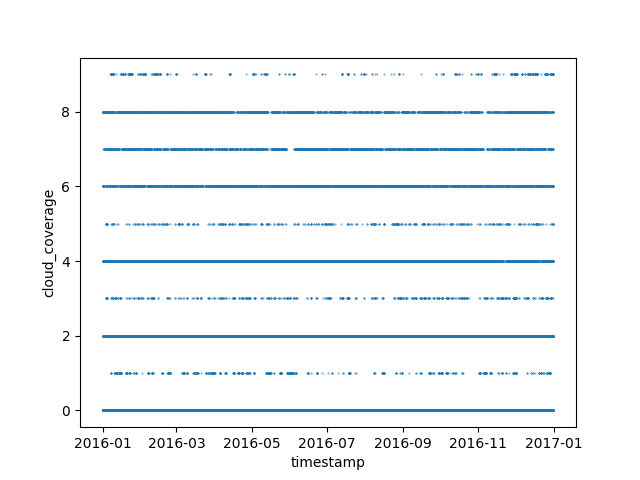

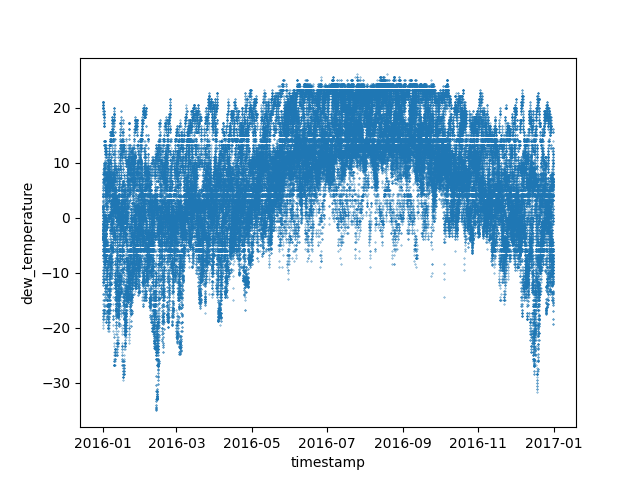

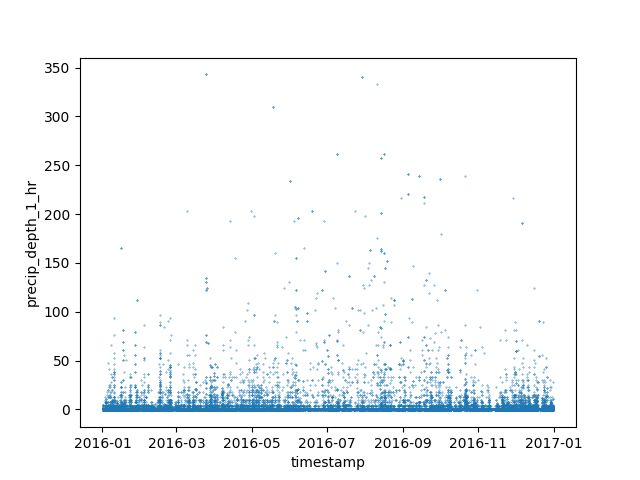

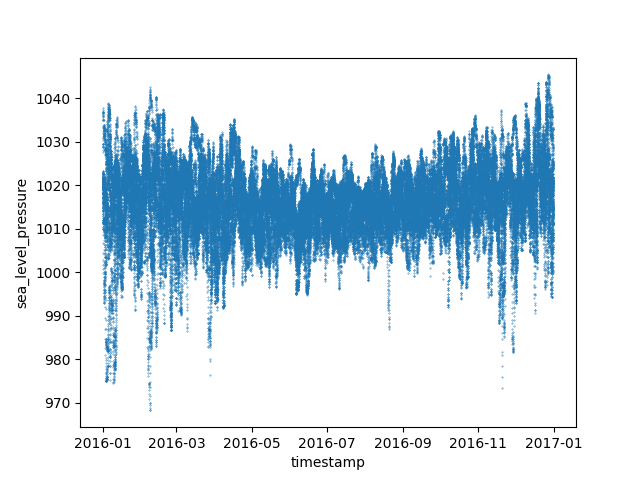

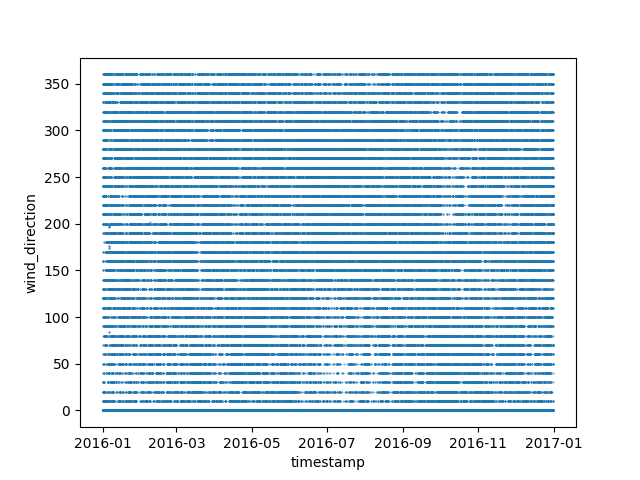

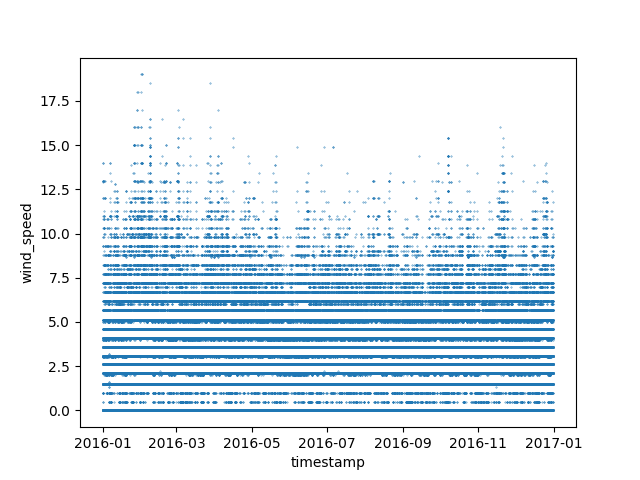

In [7]:
# Scatter plot of each reading across time
for column in weather_data.columns:
    if column not in ["timestamp", "site_id"]:
        weather_data.plot.scatter(x = "timestamp", y = column, s = 0.1)
        plt.show()

In [8]:
def process_weather(df):
    # Some site id has wrong timezone, so need to correct that (research done by other teams)
    site_GMT_offsets = [-5, 0, -7, -5, -8, 0, -5, -5, -5, -6, -7, -5, 0, -6, -5, -5]
    GMT_offset_map = {site: offset for site, offset in enumerate(site_GMT_offsets)}
    df.timestamp = df.apply(lambda x: x.timestamp + pd.offsets.Hour(GMT_offset_map[x.site_id]), axis=1)

    # Some timestamps missing in the data, need to add them (will interpolate them to fill missing readings)
    all_timestamps = pd.DataFrame(pd.date_range(start="2016-01-01 00:00:00", end="2016-12-31 23:00:00", freq='h'), columns=['timestamp'])
    all_sites = pd.DataFrame(df.site_id.unique(), columns=["site_id"])
    all_timestamps['key'] = 0
    all_sites['key'] = 0
    timestamps = pd.merge(all_timestamps, all_sites, how='inner').drop(columns = 'key')
    df = pd.merge(df, timestamps, how = "outer", on = ["timestamp", "site_id"]).sort_values(['site_id', 'timestamp'])
    
    # We interpolate missing values for weather readings
    for column in ["air_temperature", "cloud_coverage", "dew_temperature", "precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed"]:
        interpolated_readings = df.groupby('site_id')[column].transform(lambda group: group.interpolate(method='linear', limit_direction='both'))
        df[column] = df[column].fillna(interpolated_readings)
        # There are some sites where there no data at all for some readings
        df[column] = df[column].fillna(df[column].median())

    return df

In [9]:
weather_data = process_weather(weather_data)

In [10]:
# Verified no nulls in weather data
weather_data.isna().sum()

site_id               0
timestamp             0
air_temperature       0
cloud_coverage        0
dew_temperature       0
precip_depth_1_hr     0
sea_level_pressure    0
wind_direction        0
wind_speed            0
dtype: int64

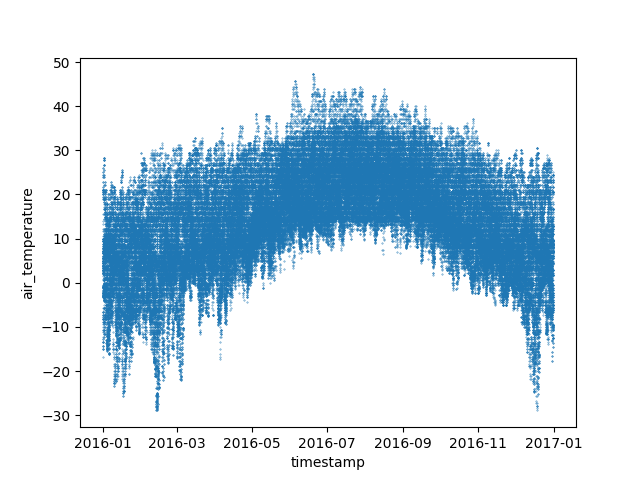

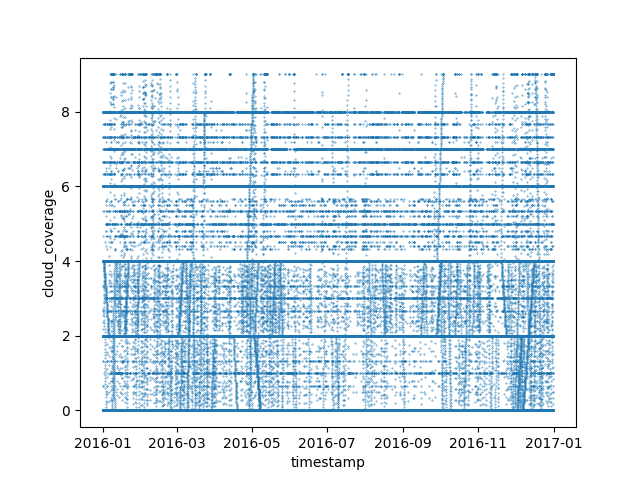

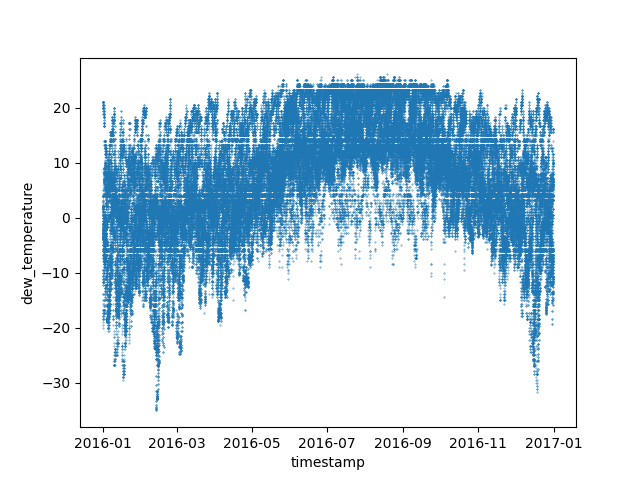

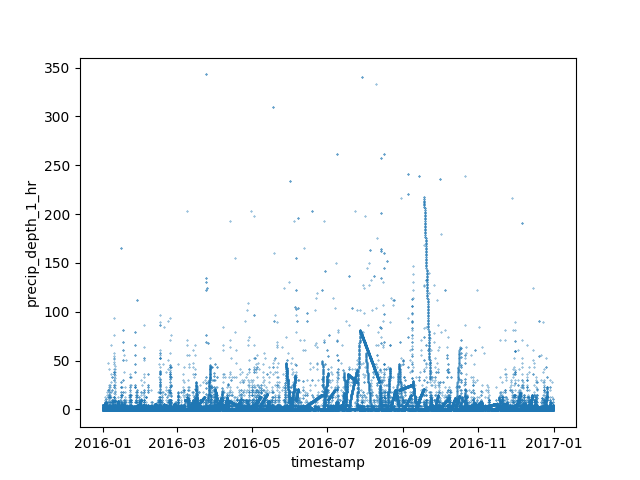

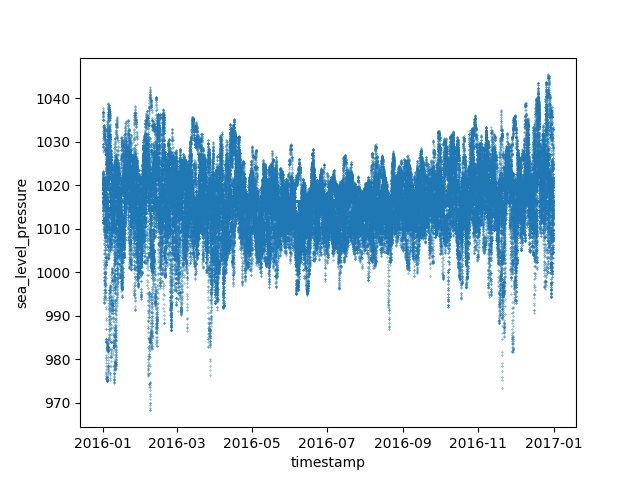

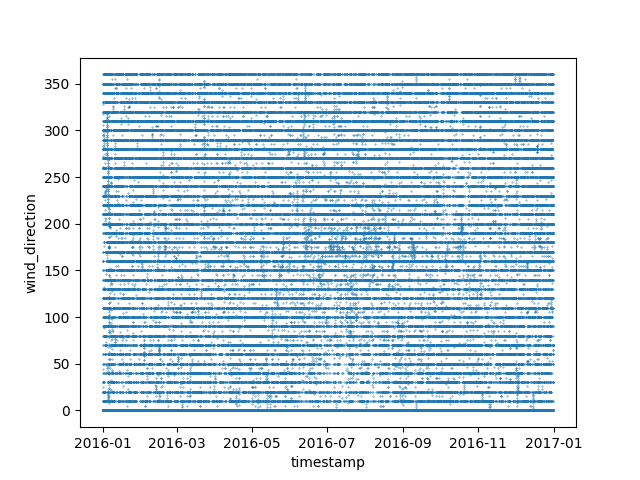

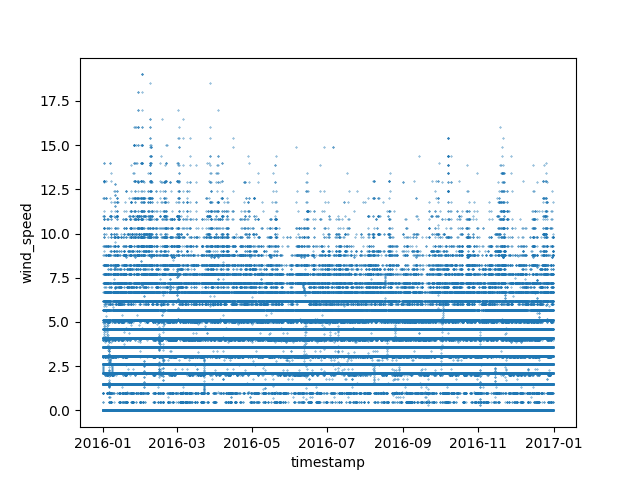

In [11]:
# View scatter plot after data interpolation
for column in weather_data.columns:
    if column not in ["timestamp", "site_id"]:
        weather_data.plot.scatter(x = "timestamp", y = column, s = 0.1)
        plt.show()

In [12]:
def get_lag_features(df, groupby, columns, window):
    for column in columns:
        rolling_df = df.groupby(groupby)[column].rolling(window=window, min_periods=0, center=True)
        df[f"{column}_lag_{window}_std"] = rolling_df.std().reset_index(level = 0, drop = True)
        df[f"{column}_lag_{window}_mean"] = rolling_df.mean().reset_index(level = 0, drop = True)
        df[f"{column}_lag_{window}_max"] = rolling_df.quantile(0.95).reset_index(level = 0, drop = True)
        df[f"{column}_lag_{window}_min"] = rolling_df.quantile(0.05).reset_index(level = 0, drop = True)

In [13]:
get_lag_features(weather_data, 'site_id', ['air_temperature', 'wind_direction', 'sea_level_pressure'], 7)

In [14]:
def get_pct_change(df, groupby, columns):
    for column in columns:
        df[f"{column}_pct_change"] = df.groupby(groupby)[column].transform(lambda group: group.pct_change(periods=1).abs() + group.pct_change(periods=-1).abs()).fillna(0.0)

In [15]:
get_pct_change(weather_data, 'site_id', ['air_temperature'])

In [16]:
weather_data

site_id           timestamp  air_temperature  cloud_coverage  \
6             0 2015-12-31 19:00:00             25.0             6.0   
16            0 2015-12-31 20:00:00             24.4             4.0   
29            0 2015-12-31 21:00:00             22.8             2.0   
42            0 2015-12-31 22:00:00             21.1             2.0   
55            0 2015-12-31 23:00:00             20.0             2.0   
...         ...                 ...              ...             ...   
140546       15 2016-12-31 19:00:00              1.7             2.0   
140562       15 2016-12-31 20:00:00              1.7             2.0   
140578       15 2016-12-31 21:00:00              1.7             2.0   
140594       15 2016-12-31 22:00:00              1.7             2.0   
140610       15 2016-12-31 23:00:00              1.7             2.0   

        dew_temperature  precip_depth_1_hr  sea_level_pressure  \
6                  20.0               -1.0              1019.7   
16                 21.1               -1.0              1020.2   
29                 21.1                0.0              1020.2   
42                 20.6                0.0              1020.1   
55                 20.0               -1.0              1020.0   
...                 ...                ...                 ...   
140546             -5.6               -1.0              1008.5   
140562             -5.6               -1.0              1008.5   
140578             -5.6               -1.0              1008.5   
140594             -5.6               -1.0              1008.5   
140610             -5.6               -1.0              1008.5   

        wind_direction  wind_speed  air_temperature_lag_7_std  ...  \
6                  0.0         0.0                   1.750000  ...   
16                70.0         1.5                   2.123205  ...   
29                 0.0         0.0                   2.318980  ...   
42                 0.0         0.0                   2.151522  ...   
55               250.0         2.6                   1.692561  ...   
...                ...         ...                        ...  ...   
140546           180.0         8.8                   0.427061  ...   
140562           180.0         8.8                   0.188982  ...   
140578           180.0         8.8                   0.000000  ...   
140594           180.0         8.8                   0.000000  ...   
140610           180.0         8.8                   0.000000  ...   

        air_temperature_lag_7_min  wind_direction_lag_7_std  \
6                          21.355                 35.000000   
16                         20.220                108.305125   
29                         19.550                100.332780   
42                         19.580                 93.782931   
55                         19.580                109.065293   
...                           ...                       ...   
140546                      1.700                  3.779645   
140562                      1.700                  3.779645   
140578                      1.700                  0.000000   
140594                      1.700                  0.000000   
140610                      1.700                  0.000000   

        wind_direction_lag_7_mean  wind_direction_lag_7_max  \
6                       17.500000                      59.5   
16                      64.000000                     214.0   
29                      53.333333                     205.0   
42                      45.714286                     196.0   
55                      75.714286                     238.0   
...                           ...                       ...   
140546                 178.571429                     180.0   
140562                 178.571429                     180.0   
140578                 180.000000                     180.0   
140594                 180.000000                     180.0   
140610                 180.000000                     180.0

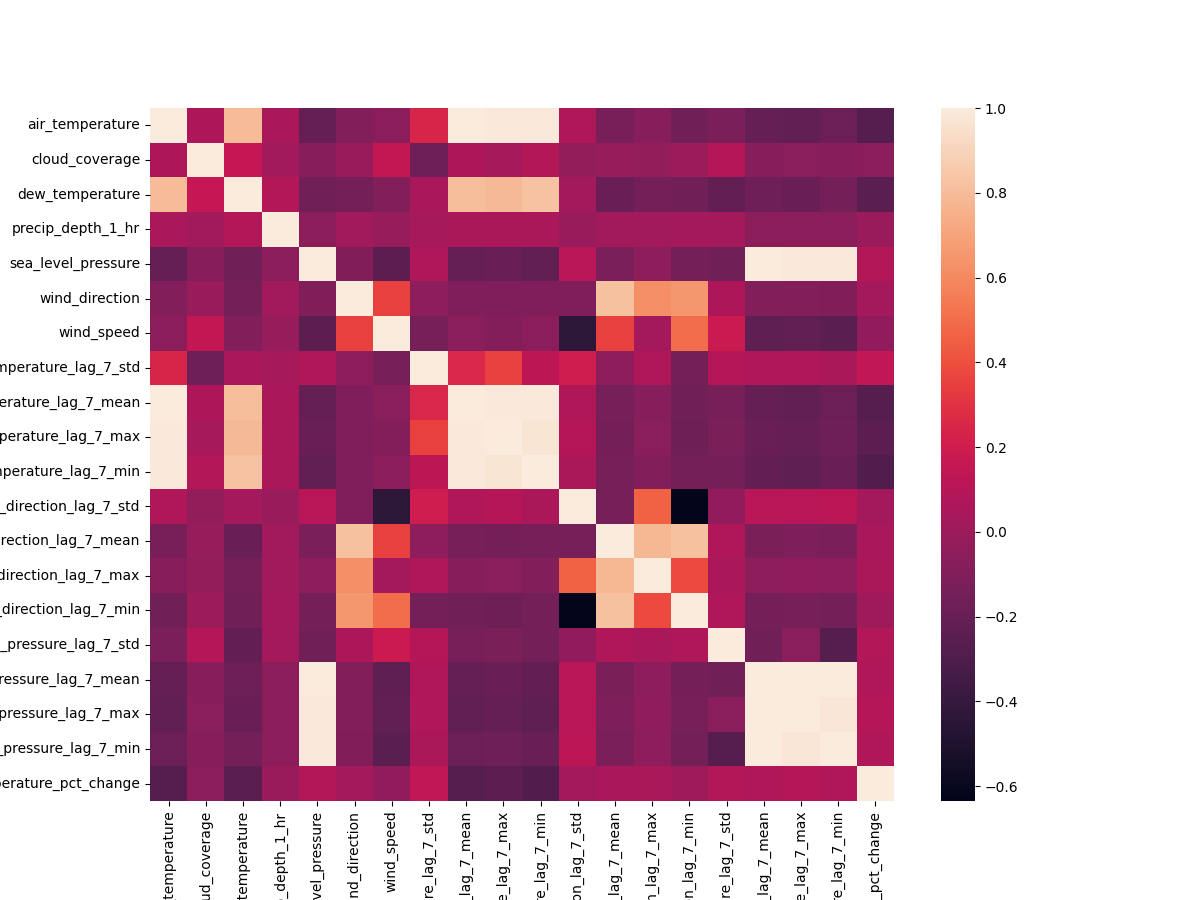

In [17]:
# Plot correlation matrix
plt.figure(figsize=(12, 9))
sns.heatmap(weather_data.drop(["site_id", "timestamp"], axis=1).corr(numeric_only=True))
plt.show()

# Building Metadata Dataset

In [18]:
building_metadata = pd.read_csv("datasets/energy-anomaly-detection/building_metadata.csv")

In [19]:
building_metadata

site_id  building_id                    primary_use  square_feet  \
0           0            0                      Education         7432   
1           0            1                      Education         2720   
2           0            2                      Education         5376   
3           0            3                      Education        23685   
4           0            4                      Education       116607   
...       ...          ...                            ...          ...   
1444       15         1444  Entertainment/public assembly        19619   
1445       15         1445                      Education         4298   
1446       15         1446  Entertainment/public assembly        11265   
1447       15         1447            Lodging/residential        29775   
1448       15         1448                         Office        92271   

      year_built  floor_count  
0         2008.0          NaN  
1         2004.0          NaN  
2         1991.0          NaN  
3         2002.0          NaN  
4         1975.0          NaN  
...          ...          ...  
1444      1914.0          NaN  
1445         NaN          NaN  
1446      1997.0          NaN  
1447      2001.0          NaN  
1448      2001.0          NaN  

[1449 rows x 6 columns]

In [20]:
building_metadata.describe()

site_id  building_id    square_feet   year_built  floor_count
count  1449.000000  1449.000000    1449.000000   675.000000   355.000000
mean      6.952381   724.000000   92111.776398  1967.957037     3.740845
std       5.003432   418.434583  110769.950997    31.054030     3.333683
min       0.000000     0.000000     283.000000  1900.000000     1.000000
25%       3.000000   362.000000   23012.000000  1949.000000     1.000000
50%       5.000000   724.000000   57673.000000  1970.000000     3.000000
75%      13.000000  1086.000000  115676.000000  1995.000000     5.000000
max      15.000000  1448.000000  875000.000000  2017.000000    26.000000

In [21]:
building_metadata.isna().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

In [22]:
def process_metadata(df):
    # Scale year built from 1900, replace NaN with median
    df["year_built"] = df["year_built"].transform(lambda x: x - x.min())
    df["year_built"] = df["year_built"].fillna(df['year_built'].median())

    # Floor count replace with median
    df["floor_count"] = df["floor_count"].fillna(df['floor_count'].median())

    return df

In [23]:
building_metadata = process_metadata(building_metadata)

In [24]:
building_metadata.isna().sum()

site_id        0
building_id    0
primary_use    0
square_feet    0
year_built     0
floor_count    0
dtype: int64

In [25]:
building_metadata

site_id  building_id                    primary_use  square_feet  \
0           0            0                      Education         7432   
1           0            1                      Education         2720   
2           0            2                      Education         5376   
3           0            3                      Education        23685   
4           0            4                      Education       116607   
...       ...          ...                            ...          ...   
1444       15         1444  Entertainment/public assembly        19619   
1445       15         1445                      Education         4298   
1446       15         1446  Entertainment/public assembly        11265   
1447       15         1447            Lodging/residential        29775   
1448       15         1448                         Office        92271   

      year_built  floor_count  
0          108.0          3.0  
1          104.0          3.0  
2           91.0          3.0  
3          102.0          3.0  
4           75.0          3.0  
...          ...          ...  
1444        14.0          3.0  
1445        70.0          3.0  
1446        97.0          3.0  
1447       101.0          3.0  
1448       101.0          3.0  

[1449 rows x 6 columns]

# Meter Reading Data

In [26]:
meter_data = pd.read_csv("datasets/energy-anomaly-detection/train.csv")

In [27]:
# Convert timestamp to datetime data type
meter_data['timestamp'] = pd.to_datetime(meter_data['timestamp'])

In [28]:
# sort meter_data
meter_data = meter_data.sort_values(["building_id", "timestamp"])

In [29]:
meter_data

building_id           timestamp  meter_reading  anomaly
0                  1 2016-01-01 00:00:00            NaN        0
200                1 2016-01-01 01:00:00            NaN        0
398                1 2016-01-01 02:00:00            NaN        0
597                1 2016-01-01 03:00:00            NaN        0
796                1 2016-01-01 04:00:00            NaN        0
...              ...                 ...            ...      ...
1748693         1353 2016-12-31 19:00:00          2.425        0
1748893         1353 2016-12-31 20:00:00          2.450        0
1749093         1353 2016-12-31 21:00:00          2.425        0
1749293         1353 2016-12-31 22:00:00          2.450        0
1749493         1353 2016-12-31 23:00:00          2.400        0

[1749494 rows x 4 columns]

In [30]:
meter_data.describe()

building_id                      timestamp  meter_reading  \
count  1.749494e+06                        1749494   1.641841e+06   
mean   7.908894e+02  2016-07-02 00:33:22.979376640   1.799018e+02   
min    1.000000e+00            2016-01-01 00:00:00   0.000000e+00   
25%    3.450000e+02            2016-04-01 14:00:00   3.000000e+01   
50%    8.960000e+02            2016-07-01 23:00:00   8.410000e+01   
75%    1.147000e+03            2016-10-01 12:00:00   1.990000e+02   
max    1.353000e+03            2016-12-31 23:00:00   6.596890e+03   
std    4.118085e+02                            NaN   3.959129e+02   

            anomaly  
count  1.749494e+06  
mean   2.131816e-02  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    1.000000e+00  
std    1.444428e-01

In [31]:
print("Fraction of Anomalies in dataset: ", meter_data[meter_data.anomaly == 1]["anomaly"].count() / meter_data["anomaly"].count())

Fraction of Anomalies in dataset:  0.02131816399484651


In [32]:
# Check for missing values
meter_data.isna().sum()

building_id           0
timestamp             0
meter_reading    107653
anomaly               0
dtype: int64

In [33]:
def check_condition(df, window):
    result = []
    for i in range(len(df)):
        start = max(i - window, 0)
        end = min(i + window + 1, len(df))
        window_values = df.iloc[start:end]
        if  not df.iloc[i:i+1].isna().any() and (1 in window_values.values or window_values.isna().any()):
            result.append(1)
        else:
            result.append(0)
    return result

def get_near_to_NA_or_1(df):
    df['near_to_NA_or_1'] = df.groupby('building_id')['meter_reading'].transform(lambda group: check_condition(group, 2))
    return df

In [34]:
meter_data = get_near_to_NA_or_1(meter_data)

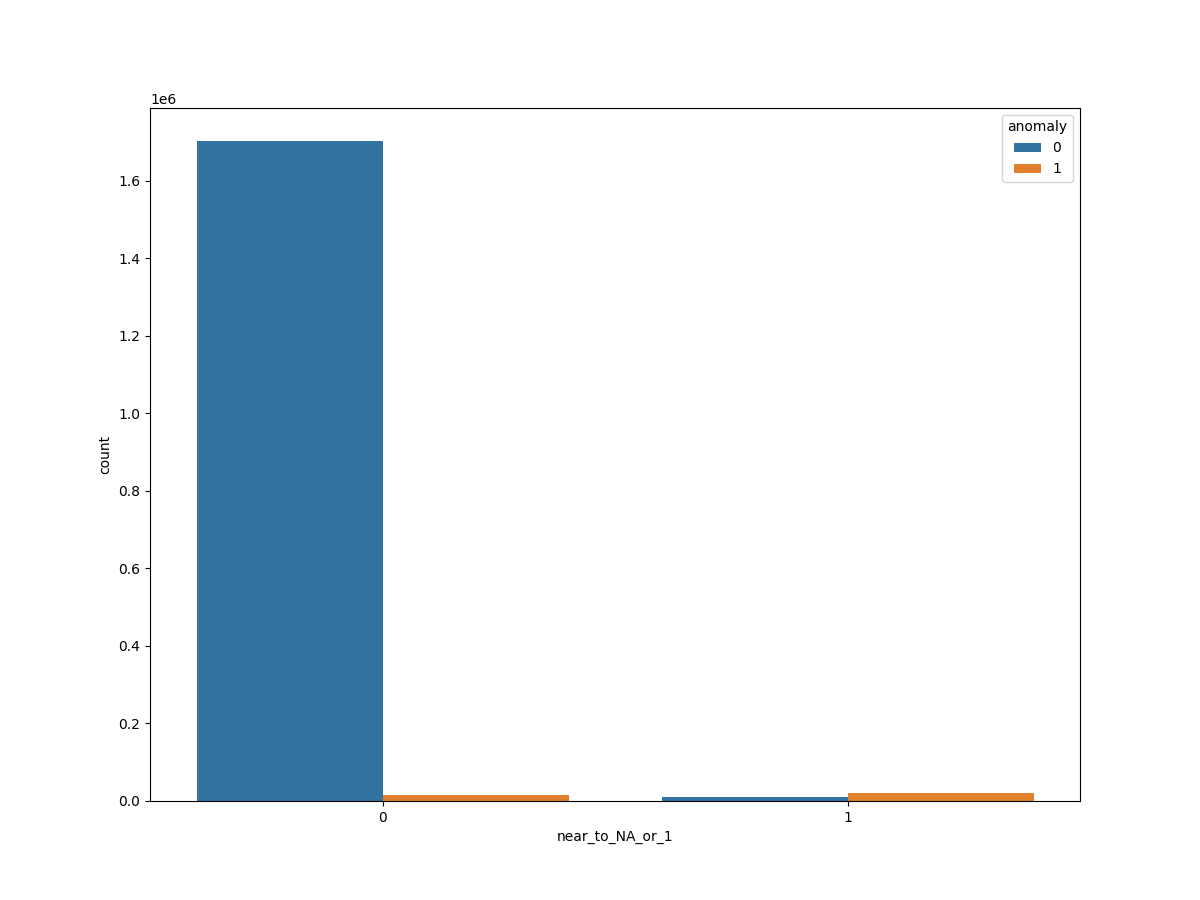

In [35]:
plt.figure(figsize=(12, 9))
sns.countplot(x="near_to_NA_or_1", data=meter_data, hue="anomaly")
plt.show()

In [36]:
def process_meter_reading(df):
    # Replace missing meter readings with median
    median_meter_readings = df.groupby('building_id')['meter_reading'].transform(lambda group: group.median())
    df["meter_reading"] = df["meter_reading"].fillna(median_meter_readings)
    return df

In [37]:
meter_data = process_meter_reading(meter_data)

In [38]:
get_lag_features(meter_data, 'building_id', ['meter_reading'], 7)

In [39]:
get_pct_change(meter_data, 'building_id', ['meter_reading'])

In [40]:
def get_holiday_or_weekend(df):
    # Define US holidays
    us_holidays = holidays.US()
    
    # Function to check if a date is a holiday or a weekend
    def is_holiday_or_weekend(timestamp):
        return int(timestamp.date() in us_holidays or timestamp.weekday() >= 5)
    
    # Apply the function to the date column
    df['is_holiday'] = df['timestamp'].apply(is_holiday_or_weekend)

    return df

In [41]:
meter_data = get_holiday_or_weekend(meter_data)

In [42]:
def get_datetime(df):
    # extract hour and month
    df['hour'] = df['timestamp'].dt.hour
    df['month'] = df['timestamp'].dt.month

In [43]:
get_datetime(meter_data)

In [44]:
meter_data

building_id           timestamp  meter_reading  anomaly  \
0                  1 2016-01-01 00:00:00         38.651        0   
200                1 2016-01-01 01:00:00         38.651        0   
398                1 2016-01-01 02:00:00         38.651        0   
597                1 2016-01-01 03:00:00         38.651        0   
796                1 2016-01-01 04:00:00         38.651        0   
...              ...                 ...            ...      ...   
1748693         1353 2016-12-31 19:00:00          2.425        0   
1748893         1353 2016-12-31 20:00:00          2.450        0   
1749093         1353 2016-12-31 21:00:00          2.425        0   
1749293         1353 2016-12-31 22:00:00          2.450        0   
1749493         1353 2016-12-31 23:00:00          2.400        0   

         near_to_NA_or_1  meter_reading_lag_7_std  meter_reading_lag_7_mean  \
0                      0                 0.000000                 38.651000   
200                    0                 0.000000                 38.651000   
398                    0                 0.000000                 38.651000   
597                    0                 0.000000                 38.651000   
796                    0                 0.000000                 38.651000   
...                  ...                      ...                       ...   
1748693                0                 0.293987                  2.389286   
1748893                0                 0.090960                  2.482143   
1749093                0                 0.071880                  2.458333   
1749293                0                 0.020917                  2.430000   
1749493                0                 0.023936                  2.431250   

         meter_reading_lag_7_max  meter_reading_lag_7_min  \
0                        38.6510                 38.65100   
200                      38.6510                 38.65100   
398                      38.6510                 38.65100   
597                      38.6510                 38.65100   
796                      38.6510                 38.65100   
...                          ...                      ...   
1748693                   2.6175                  1.95250   
1748893                   2.6175                  2.40750   
1749093                   2.5625                  2.40625   
1749293                   2.4500                  2.40500   
1749493                   2.4500                  2.40375   

         meter_reading_pct_change  is_holiday  hour  month  
0                        0.000000           1     0      1  
200                      0.000000           1     1      1  
398                      0.000000           1     2      1  
597                      0.000000           1     3      1  
796                      0.000000           1     4      1  
...                           ...         ...   ...    ...  
1748693                  0.077512           1    19     12  
1748893                  0.020619           1    20     12  
1749093                  0.020408           1    21     12  
1749293                  0.031143           1    22     12  
1749493                  0.000000           1    23     12  

[1749494 rows x 13 columns]

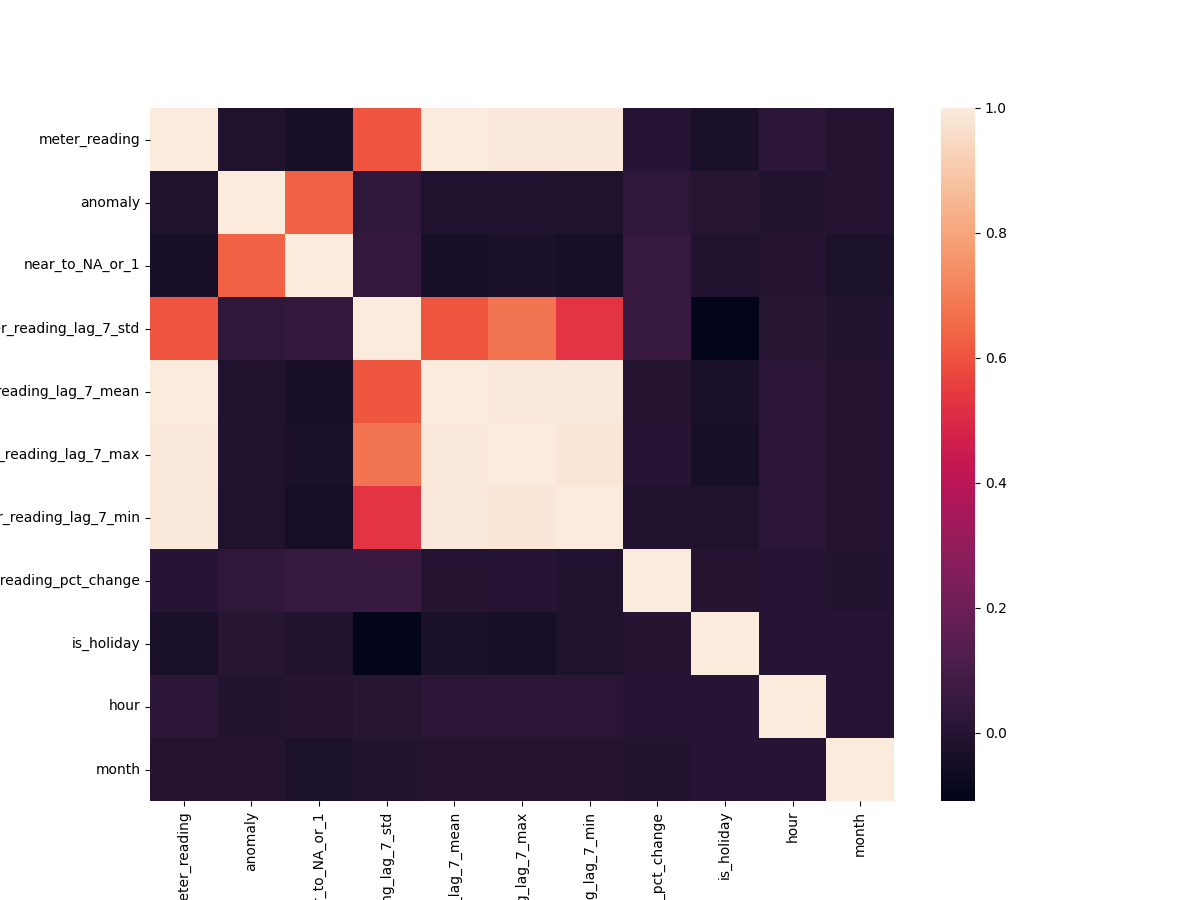

In [45]:
# Plot correlation matrix
plt.figure(figsize=(12, 9))
sns.heatmap(meter_data.drop(["building_id", "timestamp"], axis=1).corr(numeric_only=True)) 
plt.show()

# Merging Datasets + Visualization

In [46]:
# Join additional features in single dataset
data = pd.merge(meter_data, building_metadata, how = "left", on = "building_id")
data = pd.merge(data, weather_data, how = "left", on = ["site_id", "timestamp"])

In [47]:
data

building_id           timestamp  meter_reading  anomaly  \
0                  1 2016-01-01 00:00:00         38.651        0   
1                  1 2016-01-01 01:00:00         38.651        0   
2                  1 2016-01-01 02:00:00         38.651        0   
3                  1 2016-01-01 03:00:00         38.651        0   
4                  1 2016-01-01 04:00:00         38.651        0   
...              ...                 ...            ...      ...   
1749489         1353 2016-12-31 19:00:00          2.425        0   
1749490         1353 2016-12-31 20:00:00          2.450        0   
1749491         1353 2016-12-31 21:00:00          2.425        0   
1749492         1353 2016-12-31 22:00:00          2.450        0   
1749493         1353 2016-12-31 23:00:00          2.400        0   

         near_to_NA_or_1  meter_reading_lag_7_std  meter_reading_lag_7_mean  \
0                      0                 0.000000                 38.651000   
1                      0                 0.000000                 38.651000   
2                      0                 0.000000                 38.651000   
3                      0                 0.000000                 38.651000   
4                      0                 0.000000                 38.651000   
...                  ...                      ...                       ...   
1749489                0                 0.293987                  2.389286   
1749490                0                 0.090960                  2.482143   
1749491                0                 0.071880                  2.458333   
1749492                0                 0.020917                  2.430000   
1749493                0                 0.023936                  2.431250   

         meter_reading_lag_7_max  meter_reading_lag_7_min  \
0                        38.6510                 38.65100   
1                        38.6510                 38.65100   
2                        38.6510                 38.65100   
3                        38.6510                 38.65100   
4                        38.6510                 38.65100   
...                          ...                      ...   
1749489                   2.6175                  1.95250   
1749490                   2.6175                  2.40750   
1749491                   2.5625                  2.40625   
1749492                   2.4500                  2.40500   
1749493                   2.4500                  2.40375   

         meter_reading_pct_change  ...  air_temperature_lag_7_min  \
0                        0.000000  ...                      19.58   
1                        0.000000  ...                      19.58   
2                        0.000000  ...                      19.58   
3                        0.000000  ...                      19.76   
4                        0.000000  ...                      19.41   
...                           ...  ...                        ...   
1749489                  0.077512  ...                       1.70   
1749490                  0.020619  ...                       1.70   
1749491                  0.020408  ...                       1.70   
1749492                  0.031143  ...                       1.70   
1749493                  0.000000  ...                       1.70   

         wind_direction_lag_7_std  wind_direction_lag_7_mean  \
0                      112.820971                  65.714286   
1                      135.611490                 107.142857   
2                      135.611490                 107.142857   
3                      124.154282                  71.428571   
4                      129.283741                 101.428571   
...                           ...                        ...   
1749489                  3.779645                 178.571429   
1749490                  3.779645                 178.571429   
1749491                  0.000000                 180.000000   
1749492                  0.000000        

In [48]:
non_measurement_columns = ['year_built', 'building_id', 'site_id', 'anomaly', 'primary_use', 'floor_count', 'square_feet', 'timestamp', 'month', 'hour', 'is_holiday', 'near_to_NA_or_1']

In [49]:
# Normalize data
def normalize(df):
    for column in df.columns:
        if column not in non_measurement_columns:
            # df[column] = df.groupby('building_id')[column].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
            df[column] = df.groupby('building_id')[column].transform(lambda group: zscore(group)).fillna(0.0) #use zscore separately or sub for normalization?

In [50]:
# Check for missing values
data.isna().sum()

building_id                      0
timestamp                        0
meter_reading                    0
anomaly                          0
near_to_NA_or_1                  0
meter_reading_lag_7_std          0
meter_reading_lag_7_mean         0
meter_reading_lag_7_max          0
meter_reading_lag_7_min          0
meter_reading_pct_change         0
is_holiday                       0
hour                             0
month                            0
site_id                          0
primary_use                      0
square_feet                      0
year_built                       0
floor_count                      0
air_temperature                  0
cloud_coverage                   0
dew_temperature                  0
precip_depth_1_hr                0
sea_level_pressure               0
wind_direction                   0
wind_speed                       0
air_temperature_lag_7_std        0
air_temperature_lag_7_mean       0
air_temperature_lag_7_max        0
air_temperature_lag_7_min        0
wind_direction_lag_7_std         0
wind_direction_lag_7_mean        0
wind_direction_lag_7_max         0
wind_direction_lag_7_min         0
sea_level_pressure_lag_7_std     0
sea_level_pressure_lag_7_mean    0
sea_level_pressure_lag_7_max     0
sea_level_pressure_lag_7_min     0
air_temperature_pct_change       0
dtype: int64

In [51]:
normalize(data)

C:\Users\mario\miniconda3\envs\ai-practice-projects\lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\mario\miniconda3\envs\ai-practice-projects\lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\mario\miniconda3\envs\ai-practice-projects\lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\mario\miniconda3\envs\ai-practice-projects\lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\mario\miniconda3\envs\ai-practice-projects\lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\mario\miniconda3\envs\ai-practice-projects\lib\site-packages\numpy\core

In [52]:
# Label encoder primary_use feature
le = LabelEncoder()
le.fit(data["primary_use"])
le.classes_

array(['Education', 'Entertainment/public assembly',
       'Food sales and service', 'Healthcare', 'Lodging/residential',
       'Manufacturing/industrial', 'Office', 'Other', 'Parking',
       'Public services', 'Religious worship', 'Services'], dtype=object)

In [53]:
data["primary_use"] = le.transform(data["primary_use"])

In [54]:
# Check for missing values
data.isna().sum()

building_id                      0
timestamp                        0
meter_reading                    0
anomaly                          0
near_to_NA_or_1                  0
meter_reading_lag_7_std          0
meter_reading_lag_7_mean         0
meter_reading_lag_7_max          0
meter_reading_lag_7_min          0
meter_reading_pct_change         0
is_holiday                       0
hour                             0
month                            0
site_id                          0
primary_use                      0
square_feet                      0
year_built                       0
floor_count                      0
air_temperature                  0
cloud_coverage                   0
dew_temperature                  0
precip_depth_1_hr                0
sea_level_pressure               0
wind_direction                   0
wind_speed                       0
air_temperature_lag_7_std        0
air_temperature_lag_7_mean       0
air_temperature_lag_7_max        0
air_temperature_lag_7_min        0
wind_direction_lag_7_std         0
wind_direction_lag_7_mean        0
wind_direction_lag_7_max         0
wind_direction_lag_7_min         0
sea_level_pressure_lag_7_std     0
sea_level_pressure_lag_7_mean    0
sea_level_pressure_lag_7_max     0
sea_level_pressure_lag_7_min     0
air_temperature_pct_change       0
dtype: int64

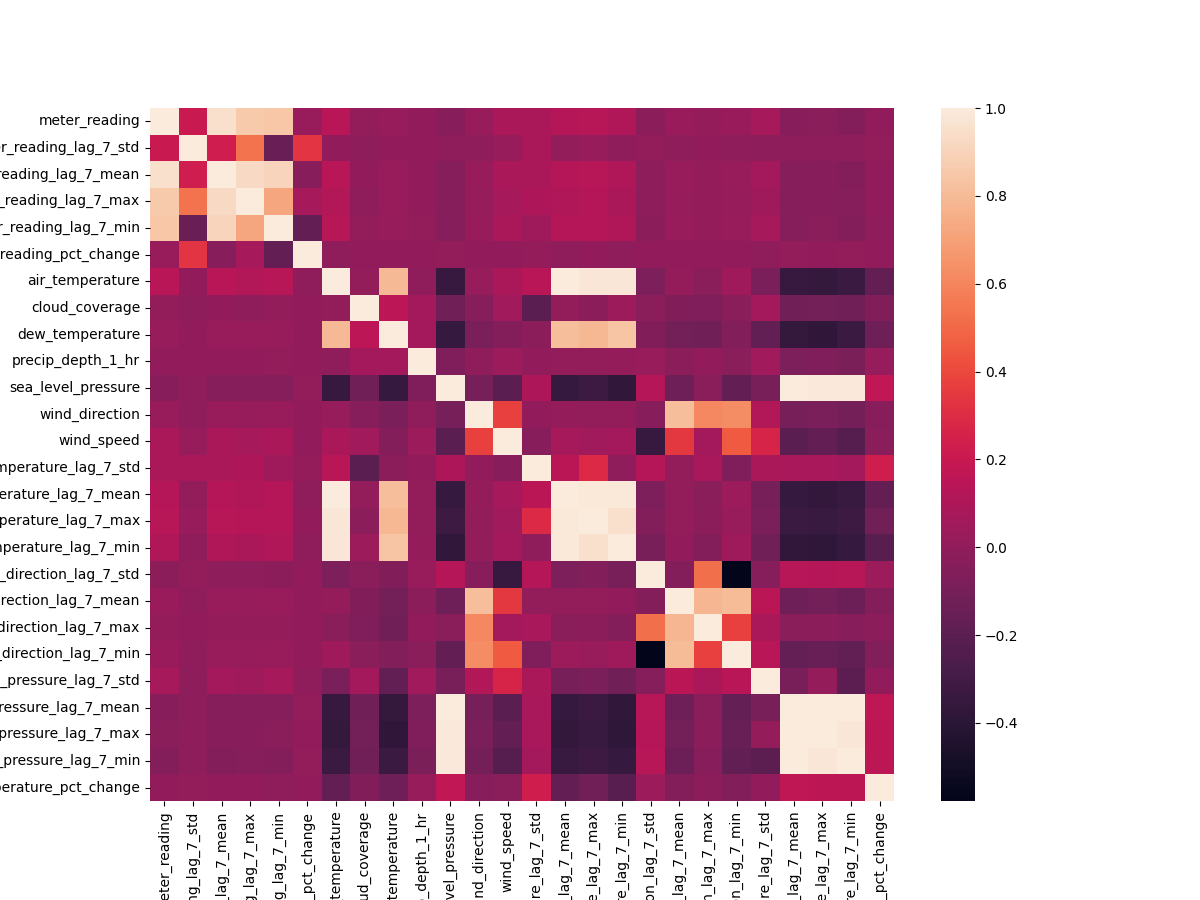

In [55]:
# Plot correlation matrix
plt.figure(figsize=(12, 9))
dataplot = sns.heatmap(data.drop(non_measurement_columns, axis=1).corr(numeric_only=True)) 
plt.show()

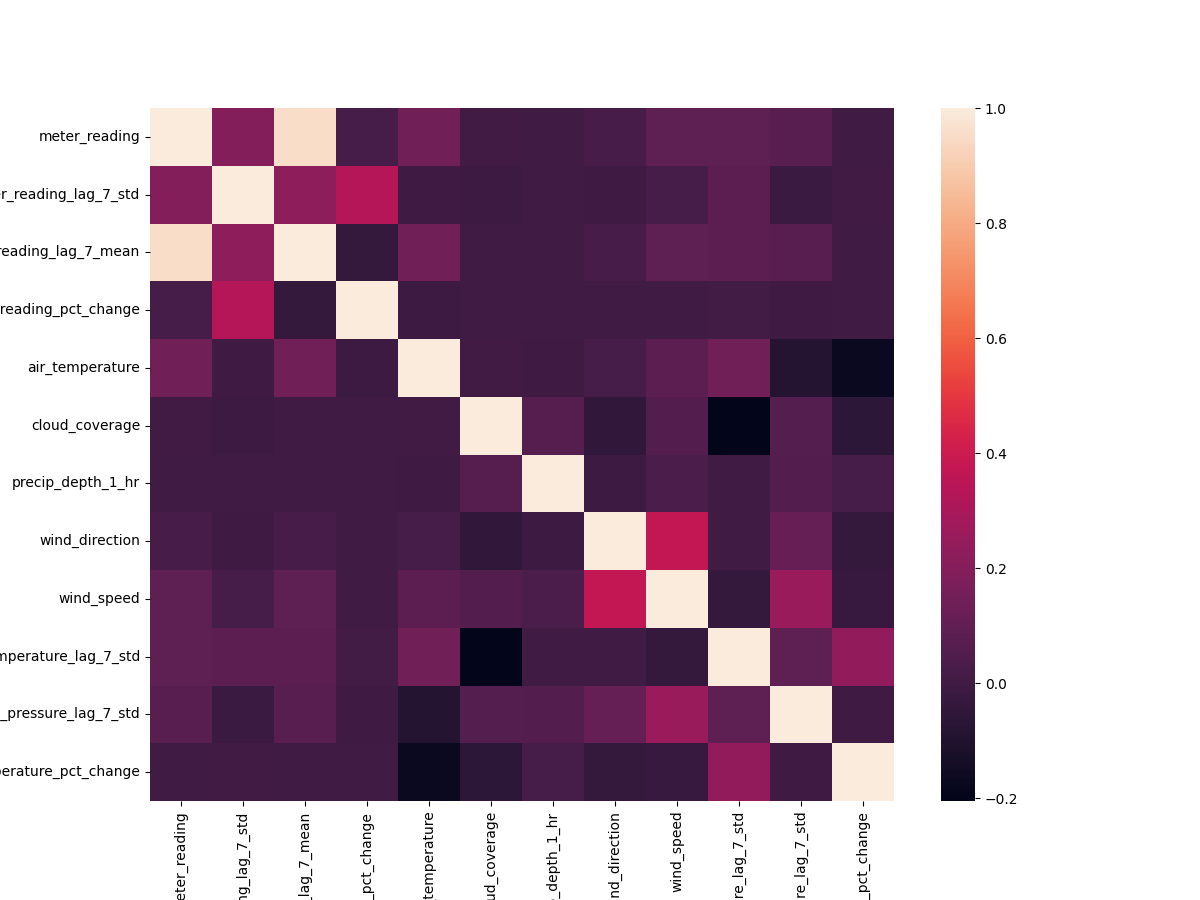

In [56]:
# Plot correlation matrix
plt.figure(figsize=(12, 9))
dataplot = sns.heatmap(data[["meter_reading", "meter_reading_lag_7_std", "meter_reading_lag_7_mean", "meter_reading_pct_change", "air_temperature",
"cloud_coverage", "precip_depth_1_hr", "wind_direction", "wind_speed", "air_temperature_lag_7_std", "sea_level_pressure_lag_7_std", "air_temperature_pct_change"]].corr(numeric_only=True)) 
plt.show()

In [57]:
def scatter_plot(x, y, c):
    plt.figure(figsize=(12, 9))
    sns.scatterplot(x=x, y=y, data=data.sample(n=1000), hue=c)
    plt.show()

In [58]:
measurement_columns = [col for col in data.columns if col not in non_measurement_columns]

In [59]:
interact(scatter_plot, x=measurement_columns, y=measurement_columns, c = "anomaly")

interactive(children=(Dropdown(description='x', options=('meter_reading', 'meter_reading_lag_7_std', 'meter_re…

<function __main__.scatter_plot(x, y, c)>

# Model Training and Evaluation

In [60]:
train_ids, val_ids = train_test_split(data["building_id"].unique().tolist(), test_size=0.20, random_state=42)

In [61]:
train_data = data[data["building_id"].isin(train_ids)]
val_data = data[data["building_id"].isin(val_ids)]

In [62]:
# drop id columns before training
train_data = train_data.drop(columns=["building_id", "site_id", "timestamp"])
val_data = val_data.drop(columns=["building_id", "site_id", "timestamp"])

In [63]:
Y_train = train_data["anomaly"]
X_train = train_data.drop(columns="anomaly")
Y_val = val_data["anomaly"]
X_val = val_data.drop(columns="anomaly")

In [64]:
def get_scores(Y, Y_pred):
    print(f"Accuracy: {accuracy_score(Y, Y_pred)}, Precision: {precision_score(Y, Y_pred)}, Recall: {recall_score(Y, Y_pred)}, F1 Score: {f1_score(Y, Y_pred)}, F2 Score: {fbeta_score(Y, Y_pred, beta=2)}, ROC: {roc_auc_score(Y, Y_pred)}")

## Isolation Forest

In [65]:
def display_confusion_matrix(Y, Y_pred):
    plt.figure(figsize=(12, 9))
    cm = confusion_matrix(Y, Y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [66]:
def evaluate(model, X, Y):
    Y_pred = model.predict(X)
    Y_pred[Y_pred == 1] = 0
    Y_pred[Y_pred == -1] = 1
    get_scores(Y, Y_pred)
    return Y_pred

In [78]:
def train(X, Y):
    # Train and predict using Isolation Forest
    model = IsolationForest(n_estimators=100, contamination=0.02, max_samples=256, max_features=1, random_state=42).fit(X)
    print("Training Results:")
    evaluate(model, X, Y)
    return model

In [79]:
def run(X_train, X_val, Y_train, Y_val, features):
    print("Training using features: ", features)
    model = train(X_train[features], Y_train)

    print("Validation Results:")
    Y_pred = evaluate(model, X_val[features], Y_val)
    # display_confusion_matrix(Y_val, Y_pred)
    print("\n\n")

In [80]:
features_list = [
    ['meter_reading', 'near_to_NA_or_1', 'meter_reading_lag_7_std',
     'meter_reading_lag_7_mean', 'meter_reading_lag_7_max',
     'meter_reading_lag_7_min', 'meter_reading_pct_change', 'is_holiday',
     'hour', 'month', 'primary_use', 'square_feet', 'year_built',
     'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature',
     'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
     'wind_speed', 'air_temperature_lag_7_std', 'air_temperature_lag_7_mean',
     'air_temperature_lag_7_max', 'air_temperature_lag_7_min',
     'wind_direction_lag_7_std', 'wind_direction_lag_7_mean',
     'wind_direction_lag_7_max', 'wind_direction_lag_7_min',
     'sea_level_pressure_lag_7_std', 'sea_level_pressure_lag_7_mean',
     'sea_level_pressure_lag_7_max', 'sea_level_pressure_lag_7_min',
     'air_temperature_pct_change'],
    
    ["meter_reading", "meter_reading_lag_7_std", "meter_reading_lag_7_mean",
    "meter_reading_lag_7_max", "meter_reading_lag_7_min", "meter_reading_pct_change"],
    
    ["meter_reading", "meter_reading_lag_7_std", "meter_reading_pct_change", 
     "air_temperature", "air_temperature_lag_7_std", "air_temperature_pct_change"],

    ["meter_reading", "meter_reading_lag_7_std", "meter_reading_pct_change", 
     "air_temperature", "air_temperature_lag_7_std", "air_temperature_pct_change", 
     "wind_direction", "sea_level_pressure"],

    ["meter_reading", "meter_reading_lag_7_std", "meter_reading_pct_change", 
     "air_temperature", "air_temperature_lag_7_std", "air_temperature_pct_change", 
     "wind_direction", "sea_level_pressure", "sea_level_pressure_lag_7_std", "wind_direction_lag_7_std"],

    ["meter_reading", "near_to_NA_or_1"],

    ["meter_reading", "near_to_NA_or_1", "air_temperature"],

    ["meter_reading", "near_to_NA_or_1", "meter_reading_lag_7_std", "meter_reading_pct_change", 
     "air_temperature", "air_temperature_lag_7_std", "air_temperature_pct_change"],

    ["meter_reading", "meter_reading_lag_7_std", "meter_reading_lag_7_mean", "meter_reading_pct_change", "air_temperature",
     "cloud_coverage", "precip_depth_1_hr", "wind_direction", "wind_speed", "air_temperature_lag_7_std", "sea_level_pressure_lag_7_std", 
     "air_temperature_pct_change"],

    ["meter_reading", "meter_reading_lag_7_std", "meter_reading_lag_7_mean", "meter_reading_pct_change", "air_temperature",
    "cloud_coverage", "precip_depth_1_hr", "wind_direction", "wind_speed", "air_temperature_lag_7_std", "sea_level_pressure_lag_7_std", 
    "air_temperature_pct_change", "near_to_NA_or_1"],

    ["meter_reading", "meter_reading_lag_7_std", "meter_reading_lag_7_mean", "meter_reading_pct_change", "air_temperature",
    "cloud_coverage", "precip_depth_1_hr", "wind_direction", "wind_speed", "air_temperature_lag_7_std", "sea_level_pressure_lag_7_std", 
    "air_temperature_pct_change", "near_to_NA_or_1", "hour", "month", "primary_use", "square_feet"],

    ['meter_reading', 'meter_reading_lag_7_std', 'meter_reading_lag_7_mean', 'meter_reading_lag_7_max', 
     'meter_reading_lag_7_min', 'meter_reading_pct_change', 'near_to_NA_or_1']
]

In [81]:
for features in features_list:
    run(X_train, X_val, Y_train, Y_val, features)

Training using features:  ['meter_reading', 'near_to_NA_or_1', 'meter_reading_lag_7_std', 'meter_reading_lag_7_mean', 'meter_reading_lag_7_max', 'meter_reading_lag_7_min', 'meter_reading_pct_change', 'is_holiday', 'hour', 'month', 'primary_use', 'square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed', 'air_temperature_lag_7_std', 'air_temperature_lag_7_mean', 'air_temperature_lag_7_max', 'air_temperature_lag_7_min', 'wind_direction_lag_7_std', 'wind_direction_lag_7_mean', 'wind_direction_lag_7_max', 'wind_direction_lag_7_min', 'sea_level_pressure_lag_7_std', 'sea_level_pressure_lag_7_mean', 'sea_level_pressure_lag_7_max', 'sea_level_pressure_lag_7_min', 'air_temperature_pct_change']
Training Results:
Accuracy: 0.9649010716493538, Precision: 0.14779346078256209, Recall: 0.14068505731487466, F1 Score: 0.14415167991077651, F2 Score: 0.14205150397373284, ROC: 0.561637535541